In [25]:
# -------------------------------
# Imports
# -------------------------------
import numpy as np
import pandas as pd
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
import time
import gc
import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Load Data
# -------------------------------
X_train = pd.read_csv('../data/X_train_encoded.csv')
X_test  = pd.read_csv('../data/X_test_encoded.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test  = pd.read_csv('../data/y_test.csv')

# Map target to numeric
y_train_numeric = y_train['Target'].map({'Low': 0, 'Medium': 1, 'High': 2}).values
y_test_numeric  = y_test['Target'].map({'Low': 0, 'Medium': 1, 'High': 2}).values

num_classes = len(np.unique(y_train_numeric))
print(f"Number of classes: {num_classes}")


Number of classes: 3


In [26]:
X_train.shape

(7694, 176)

In [22]:
corr = X_train.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

to_drop = [
    col for col in upper.columns
    if any(upper[col] > 0.95)
]

to_drop

['financial_access_score',
 'insurance_age',
 'insurance_ratio',
 'total_economic_capacity',
 'financial_access_country',
 'insurance_country_weighted',
 'attitude_worried_shutdown_Unknown',
 'motor_vehicle_insurance_Unknown',
 'has_cellphone_Unknown',
 'owner_sex_Unknown',
 'offers_credit_to_customers_Unknown',
 'attitude_satisfied_with_achievement_Unknown',
 'has_credit_card_Unknown',
 'keeps_financial_records_Unknown',
 'perception_insurance_companies_dont_insure_businesses_like_yours_Unknown',
 'perception_insurance_important_Unknown',
 'has_insurance_No',
 'has_insurance_Unknown',
 'has_insurance_Yes',
 'covid_essential_service_Unknown',
 'attitude_more_successful_next_year_Unknown',
 'has_loan_account_Have_now',
 'has_internet_banking_Unknown',
 'has_debit_card_Unknown',
 'medical_insurance_Never_had',
 'funeral_insurance_Never_had',
 'funeral_insurance_Unknown',
 'uses_informal_lender_Unknown']

In [23]:
# Drop unwanted features
X_train = X_train.drop(columns=to_drop, errors='ignore')
X_test  = X_test.drop(columns=to_drop, errors='ignore')

print(f"Dropped {len(to_drop)} columns. New shape: {X_train.shape}")


Dropped 28 columns. New shape: (7694, 148)


In [ ]:

# -------------------------------
# Optuna objective for RandomForest
# -------------------------------
from sklearn.model_selection import StratifiedGroupKFold


def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical(
            'class_weight', [None, 'balanced', 'balanced_subsample']
        ),
        'n_jobs': -1,
        'random_state': 2026
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    logo = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)  # Leave one country out

  
    logloss_scores = []

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train_numeric)):

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train_numeric[train_idx], y_train_numeric[valid_idx]

        model = RandomForestClassifier(**params)
        model.fit(X_tr, y_tr)

        pred_val = model.predict_proba(X_val)
        fold_logloss = log_loss(y_val, pred_val)

        logloss_scores.append(fold_logloss)

        # ---- Optuna pruning (fold-based) ----
        trial.report(fold_logloss, step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(logloss_scores)


(7694, 179) (1924, 179)


In [32]:

# -------------------------------
# Optuna study
# -------------------------------
debug = True
timeout = 60 if debug else 3600  # 1 min debug / 1 hour full

start = time.time()

sampler = optuna.samplers.TPESampler(
    n_startup_trials=30,
    multivariate=True
)

pruner = optuna.pruners.SuccessiveHalvingPruner(
    min_resource=2,
    reduction_factor=4,
    min_early_stopping_rate=1
)

study = optuna.create_study(
    direction='minimize',
    sampler=sampler,
    pruner=pruner
)

study.optimize(objective, n_trials=30, timeout=timeout)

end = time.time()

print(f"Optuna finished in {end - start:.2f} seconds")
print("Best params:", study.best_params)
print("Best CV multi_logloss:", study.best_value)

# -------------------------------
# Train final RandomForest model
# -------------------------------
best_params = study.best_params
best_params.update({
    'n_jobs': -1,
    'random_state': 2026
})

print("\nTraining final RandomForest model on full training data...")
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train, y_train_numeric)

# -------------------------------
# Evaluate on test set
# -------------------------------
pred_test = final_model.predict_proba(X_test)

roc_auc = roc_auc_score(
    y_test_numeric,
    pred_test,
    multi_class='ovr',
    average='weighted'
)

logloss = log_loss(y_test_numeric, pred_test)
accuracy = np.mean(np.argmax(pred_test, axis=1) == y_test_numeric)

print("\n--- Test set performance ---")
print(f"ROC AUC (OVR weighted): {roc_auc:.5f}")
print(f"Log Loss:           {logloss:.5f}")
print(f"Accuracy:           {accuracy:.5f}")

gc.collect()


[I 2026-01-03 01:09:29,183] A new study created in memory with name: no-name-705530e1-013b-4e18-8f6b-0f223461466f
[I 2026-01-03 01:09:34,463] Trial 0 finished with value: 0.40382092707270556 and parameters: {'n_estimators': 289, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': 0.5946965844795485, 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.40382092707270556.
[I 2026-01-03 01:09:52,280] Trial 1 finished with value: 0.48924090327843484 and parameters: {'n_estimators': 855, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.4518500288854298, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.40382092707270556.
[I 2026-01-03 01:10:20,541] Trial 2 finished with value: 0.45105748286137404 and parameters: {'n_estimators': 1250, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 18, 'max_features': 0.8739670889068625, 'bootstrap': True, 'class_weight': 'balanced'}. 

Optuna finished in 64.72 seconds
Best params: {'n_estimators': 289, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': 0.5946965844795485, 'bootstrap': False, 'class_weight': None}
Best CV multi_logloss: 0.40382092707270556

Training final RandomForest model on full training data...

--- Test set performance ---
ROC AUC (OVR weighted): 0.94277
Log Loss:           0.31190
Accuracy:           0.87318


116

In [56]:
# Keep features above median importance
from sklearn.feature_selection import SelectFromModel


selector = SelectFromModel(final_model, threshold='median', prefit=True)

# Transform train and test sets
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# Optional: get selected feature names
selected_features = X_train.columns[selector.get_support()]
print("Selected features:", selected_features.tolist())
print("Number of features:", X_train_sel.shape[1])


Selected features: ['owner_age', 'personal_income', 'business_expenses', 'business_turnover', 'business_age_years', 'owner_age_x_business_turnover', 'personal_income_plus_business_turnover', 'business_turnover_plus_business_age_years', 'owner_age_plus_business_turnover', 'business_turnover_x_business_age_years', 'business_expenses_plus_business_turnover', 'owner_age_x_personal_income', 'personal_income_plus_business_age_years', 'personal_income_x_business_turnover', 'owner_age_plus_personal_income', 'personal_income_x_business_age_years', 'owner_age_div_personal_income', 'business_expenses_x_business_turnover', 'business_turnover_x_business_age_months', 'owner_age_div_business_age_months', 'personal_income_x_business_expenses', 'business_turnover_plus_business_age_months', 'owner_age_plus_business_age_months', 'owner_age_plus_business_age_years', 'personal_income_plus_business_expenses', 'business_expenses_div_business_age_months', 'personal_income_x_business_age_months', 'business_exp

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss

# Use the same best params
final_model_sel = RandomForestClassifier(**best_params)

# Retrain
final_model_sel.fit(X_train_sel, y_train_numeric)

# Predict on test set
pred_test_sel = final_model_sel.predict_proba(X_test_sel)

# Evaluate
roc_auc_sel = roc_auc_score(y_test_numeric, pred_test_sel, multi_class='ovr', average='weighted')
logloss_sel = log_loss(y_test_numeric, pred_test_sel)
accuracy_sel = np.mean(np.argmax(pred_test_sel, axis=1) == y_test_numeric)

print("\n--- Test set performance after feature selection ---")
print(f"ROC AUC (OVR weighted): {roc_auc_sel:.5f}")
print(f"Log Loss:               {logloss_sel:.5f}")
print(f"Accuracy:               {accuracy_sel:.5f}")



--- Test set performance after feature selection ---
ROC AUC (OVR weighted): 0.93708
Log Loss:               0.33651
Accuracy:               0.86850


In [45]:

# -------------------------------
# Optuna study
# -------------------------------
debug = True
timeout = 60 if debug else 3600  # 1 min debug / 1 hour full

start = time.time()

sampler = optuna.samplers.TPESampler(
    n_startup_trials=30,
    multivariate=True
)

pruner = optuna.pruners.SuccessiveHalvingPruner(
    min_resource=2,
    reduction_factor=4,
    min_early_stopping_rate=1
)

study = optuna.create_study(
    direction='minimize',
    sampler=sampler,
    pruner=pruner
)

study.optimize(objective, n_trials=30, timeout=timeout)

end = time.time()

print(f"Optuna finished in {end - start:.2f} seconds")
print("Best params:", study.best_params)
print("Best CV multi_logloss:", study.best_value)

# -------------------------------
# Train final RandomForest model
# -------------------------------
best_params = study.best_params
best_params.update({
    'n_jobs': -1,
    'random_state': 2026
})

print("\nTraining final RandomForest model on full training data...")
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train, y_train_numeric)

# -------------------------------
# Evaluate on test set
# -------------------------------
pred_test = final_model.predict_proba(X_test)

roc_auc = roc_auc_score(
    y_test_numeric,
    pred_test,
    multi_class='ovr',
    average='weighted'
)

logloss = log_loss(y_test_numeric, pred_test)
accuracy = np.mean(np.argmax(pred_test, axis=1) == y_test_numeric)

print("\n--- Test set performance ---")
print(f"ROC AUC (OVR weighted): {roc_auc:.5f}")
print(f"Log Loss:           {logloss:.5f}")
print(f"Accuracy:           {accuracy:.5f}")

gc.collect()


[I 2026-01-02 22:32:23,311] A new study created in memory with name: no-name-df2e5954-4aef-40b5-a6aa-fbc20e83adee
[I 2026-01-02 22:32:59,437] Trial 0 finished with value: 0.3531860027618069 and parameters: {'n_estimators': 1336, 'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 16, 'max_features': 0.9084325210331317, 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.3531860027618069.
[I 2026-01-02 22:33:26,091] Trial 1 finished with value: 0.3095230573497754 and parameters: {'n_estimators': 1423, 'max_depth': 27, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 0.6376961547042783, 'bootstrap': True, 'class_weight': None}. Best is trial 1 with value: 0.3095230573497754.


Optuna finished in 62.78 seconds
Best params: {'n_estimators': 1423, 'max_depth': 27, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 0.6376961547042783, 'bootstrap': True, 'class_weight': None}
Best CV multi_logloss: 0.3095230573497754

Training final RandomForest model on full training data...

--- Test set performance ---
ROC AUC (OVR weighted): 0.94206
Log Loss:           0.31353
Accuracy:           0.87474


261

In [7]:
import optuna.visualization as vis



# Slice plot for individual params
vis.plot_slice(study)


In [8]:
vis.plot_param_importances(study)


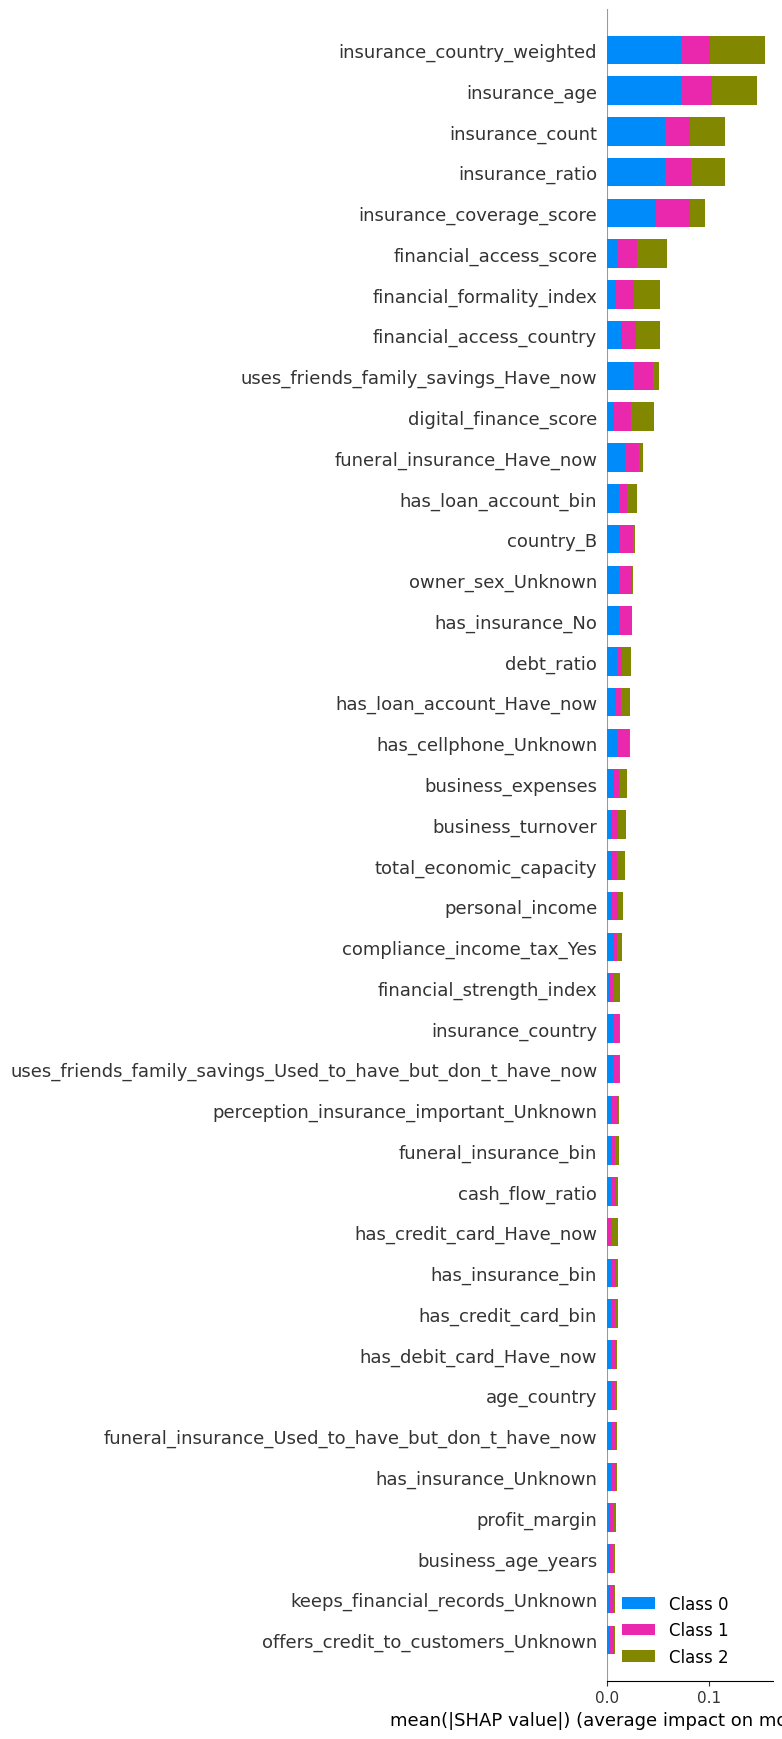

In [22]:
import shap
import numpy as np
X_shap = X_train.sample(1000, random_state=42)  # reduce if slow
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    max_display=40,
    class_names=[f"Class {i}" for i in range(len(shap_values))]
)


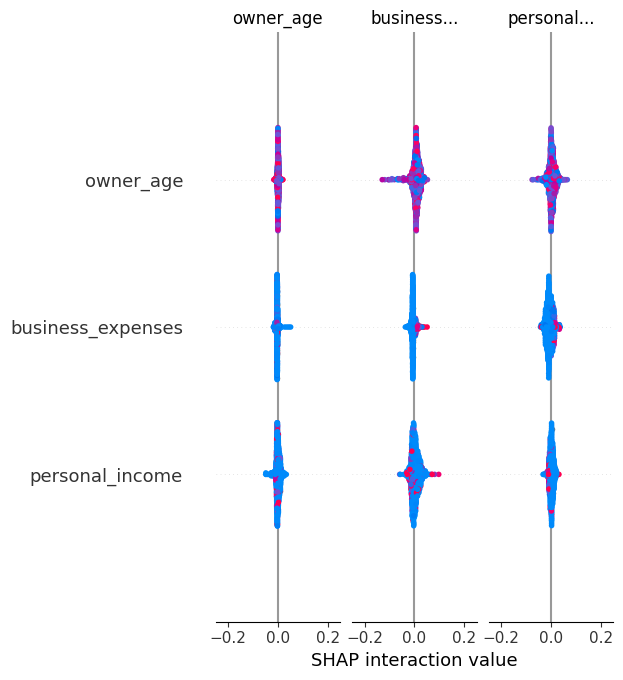

In [11]:
shap.summary_plot(
    shap_values,
    X_shap,
    class_names=[f"Class {i}" for i in range(len(shap_values))]
)


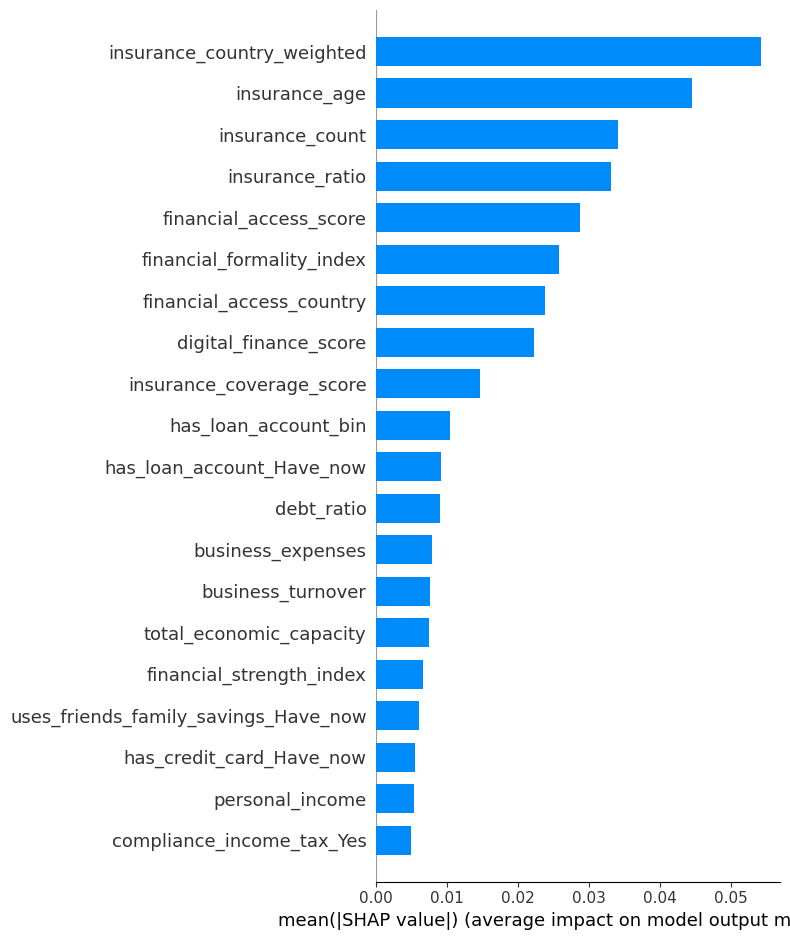

In [ ]:
def get_shap_for_class(shap_values, class_idx):
    shap_arr = np.array(shap_values)
    if shap_arr.ndim == 3:
        return shap_arr[:, :, class_idx]
    else:
        return shap_values[class_idx]

shap_c2 = get_shap_for_class(shap_values, 2)

shap.summary_plot(shap_c2, X_shap, plot_type="bar")


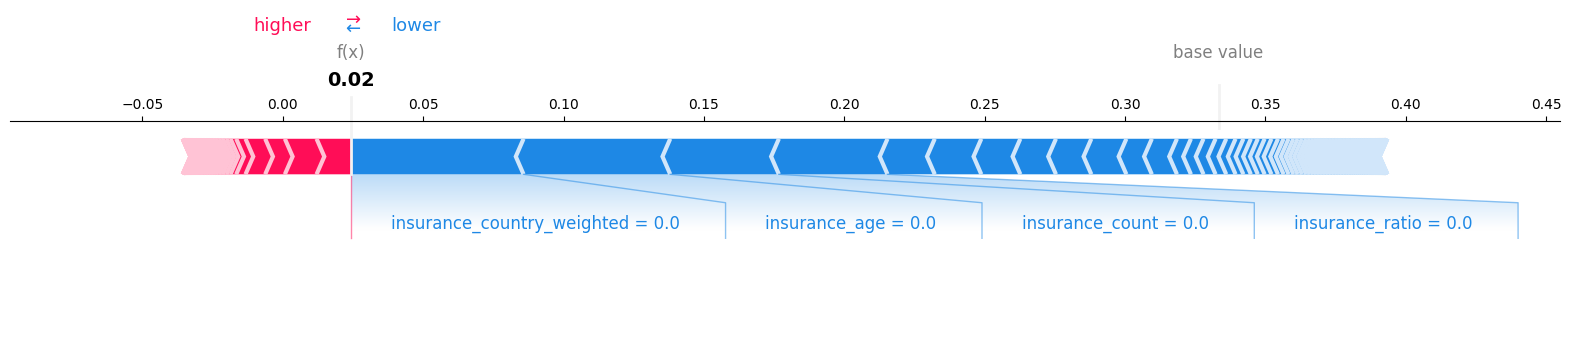

In [20]:
def shap_for_instance(shap_values, idx, class_id):
    shap_arr = np.array(shap_values)
    if shap_arr.ndim == 3:
        return shap_arr[idx, :, class_id]
    else:
        return shap_values[class_id][idx]



shap.force_plot(
    explainer.expected_value[2],
    shap_for_instance(shap_values, idx=5, class_id=2),
    X_shap.iloc[5],
    matplotlib=True
)


In [21]:
mean_abs_shap = np.mean(
    np.abs(np.stack(shap_values)),
    axis=(0, 1)
)

shap_importance = (
    pd.DataFrame({
        'feature': X_shap.columns,
        'importance': mean_abs_shap
    })
    .sort_values('importance', ascending=False)
)

shap_importance.head(15)


ValueError: All arrays must be of the same length

In [16]:
rf_importance = pd.Series(
    final_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

rf_importance.head(10)


insurance_country_weighted              0.101636
insurance_age                           0.089261
insurance_count                         0.065992
insurance_ratio                         0.065031
financial_access_score                  0.049805
financial_formality_index               0.044969
financial_access_country                0.042116
digital_finance_score                   0.034886
insurance_coverage_score                0.034414
uses_friends_family_savings_Have_now    0.022352
dtype: float64